In [1]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision

In [2]:
class ContractingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout = False, use_bn = True):
        super(ContractingBlock, self).__init__()
        self.use_bn = use_bn
        self.use_dropout = use_dropout
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias = False)
        if use_bn : 
            self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.LeakyReLU(0.2)
        if use_dropout :
            self.dropout1 = nn.Dropout(0.5)
            
    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn :
            x = self.batchnorm(x)
        return self.dropout1(x) if self.use_dropout else x
    
class ExpandingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout = False):
        super(ExpandingBlock, self).__init__()
        self.use_dropout = use_dropout
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, bias = False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        if use_dropout :
            self.dropout1 = nn.Dropout(0.5)
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        return self.dropout1(x) if self.use_dropout else x
    
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_channels = 64):
        super(UNet, self).__init__()
        self.con1 = ContractingBlock(in_channels, hidden_channels, use_dropout = False, use_bn = False)
        self.con2 = ContractingBlock(hidden_channels, hidden_channels*2, use_dropout = False, use_bn = True)
        self.con3 = ContractingBlock(hidden_channels*2, hidden_channels*4, use_dropout = False, use_bn = True)
        self.con4 = ContractingBlock(hidden_channels*4, hidden_channels*8, use_dropout = False, use_bn = True)
        self.con5 = ContractingBlock(hidden_channels*8, hidden_channels*8, use_dropout = False, use_bn = True)
        self.con6 = ContractingBlock(hidden_channels*8, hidden_channels*8, use_dropout = False, use_bn = True)
        self.con7 = ContractingBlock(hidden_channels*8, hidden_channels*8, use_dropout = False, use_bn = True)
        self.con8 = ContractingBlock(hidden_channels*8, hidden_channels*8, use_dropout = False, use_bn = False)
    
        self.exp1 = ExpandingBlock(hidden_channels*8, hidden_channels*8, use_dropout = True)
        self.exp2 = ExpandingBlock(hidden_channels*16, hidden_channels*8, use_dropout = True)
        self.exp3 = ExpandingBlock(hidden_channels*16, hidden_channels*8, use_dropout = True)
        self.exp4 = ExpandingBlock(hidden_channels*16, hidden_channels*8, use_dropout = True)
        self.exp5 = ExpandingBlock(hidden_channels*16, hidden_channels*4, use_dropout = False)
        self.exp6 = ExpandingBlock(hidden_channels*8, hidden_channels*2, use_dropout = False)
        self.exp7 = ExpandingBlock(hidden_channels*4, hidden_channels, use_dropout = False)
        self.final = nn.Sequential(
            nn.ConvTranspose2d(hidden_channels*2, out_channels, kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh(),
        )
    
    def forward(self, x):
        c1 = self.con1(x)
        c2 = self.con2(c1)
        c3 = self.con3(c2)
        c4 = self.con4(c3)
        c5 = self.con5(c4)
        c6 = self.con6(c5)
        c7 = self.con7(c6)
        c8 = self.con8(c7)
        e1 = self.exp1(c8)
        e2 = self.exp2(torch.cat([e1, c7], axis = 1))
        e3 = self.exp3(torch.cat([e2, c6], axis = 1))
        e4 = self.exp4(torch.cat([e3, c5], axis = 1))
        e5 = self.exp5(torch.cat([e4, c4], axis = 1))
        e6 = self.exp6(torch.cat([e5, c3], axis = 1))
        e7 = self.exp7(torch.cat([e6, c2], axis = 1))
        e8 = self.final(torch.cat([e7, c1], axis = 1))
        return e8
        

In [3]:
def test():
    x = torch.randn((1, 3, 256, 256))
    model = UNet(in_channels=3, out_channels = 3, hidden_channels=64)
    preds = model(x)
    print(preds.shape)

In [4]:
test()

torch.Size([1, 3, 256, 256])


In [5]:
class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels):
        super(PatchGANDiscriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size = 4, stride = 2, padding = 1),
            nn.LeakyReLU(0.2),
            self.con_block(64, 128, 4, 2, 1),
            self.con_block(128, 256, 4, 2, 1),
            self.con_block(256, 512, 4, 1, 1),
            nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 1)
        )
    
    def con_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def forward(self, img_1, img_2):
        img = torch.cat([img_1, img_2], 1)
        return self.disc(img)

In [6]:
def test():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = PatchGANDiscriminator(in_channels=6)
    preds = model(x, y)
    print(preds.shape)

In [7]:
test()

torch.Size([1, 1, 30, 30])


In [8]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02),
        torch.nn.init.normal_(m.bias, 0)

In [9]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class MapDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_files = os.listdir(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_image = image[:, :600, :]
        target_image = image[:, 600:, :]
        input_image = Image.fromarray(input_image)
        target_image = Image.fromarray(target_image)

        if self.transform :
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
     transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = MapDataset("/kaggle/input/pix2pix-dataset/maps/maps/train/", transform = transform)

dataloader = DataLoader(dataset, batch_size= 16)

# for sat, real in loader:
#         print(sat.shape)
#         print(sat[0][0].size())
#         print(real[0][0].size())
#         save_image(sat, "sat.png")
#         save_image(real, "real.png")
#         break;

In [11]:
gan_criterion1 = nn.BCEWithLogitsLoss()
gan_criterion2 = nn.L1Loss()

n_epochs = 20
img_channels = 3
lr = 0.0002
device = 'cuda'
beta_1 = 0.5
beta_2 = 0.999
steps = 100

In [12]:
gen = UNet(3, 3, 64).to(device)
disc = PatchGANDiscriminator(6).to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr = lr, betas = (beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr, betas = (beta_1, beta_2))

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    img = img.detach().cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Epochs: 1 Step: 100 Generator loss: 20.864298315048217, discriminator loss: 0.6119915580749512


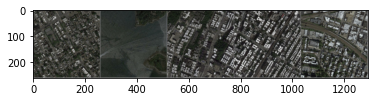

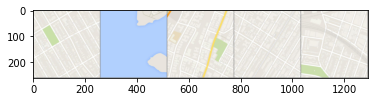

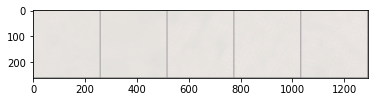

Epochs: 2 Step: 200 Generator loss: 12.824996118545533, discriminator loss: 0.3786449843645096


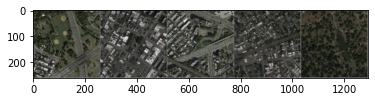

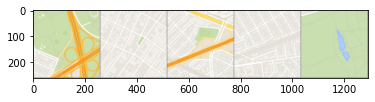

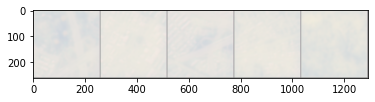

Epochs: 4 Step: 300 Generator loss: 12.515162534713745, discriminator loss: 0.19313277989625932


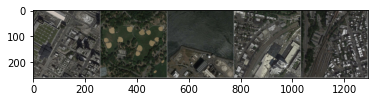

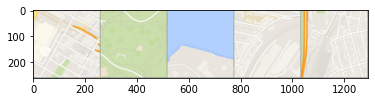

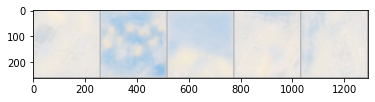

Epochs: 5 Step: 400 Generator loss: 12.999465847015381, discriminator loss: 0.09098483331501483


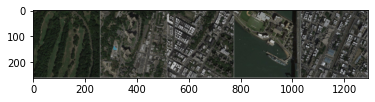

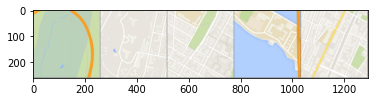

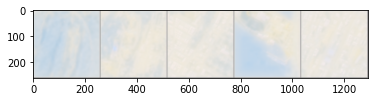

Epochs: 7 Step: 500 Generator loss: 13.433743343353271, discriminator loss: 0.04752969264984131


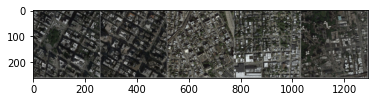

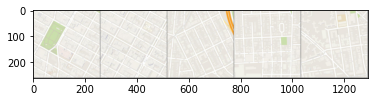

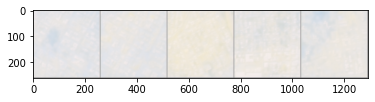

Epochs: 8 Step: 600 Generator loss: 13.851863775253296, discriminator loss: 0.02796988148242235


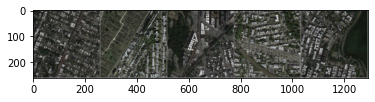

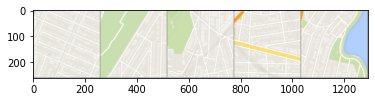

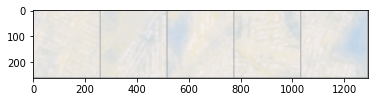

Epochs: 10 Step: 700 Generator loss: 14.264724254608154, discriminator loss: 0.018084284933283925


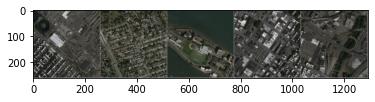

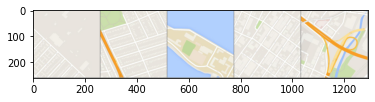

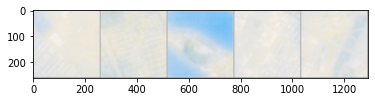

Epochs: 11 Step: 800 Generator loss: 14.61511715888977, discriminator loss: 0.012531827436760068


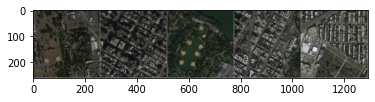

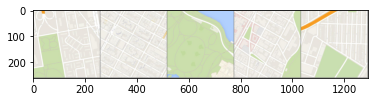

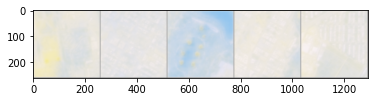

Epochs: 13 Step: 900 Generator loss: 14.85148362159729, discriminator loss: 0.009198159286752343


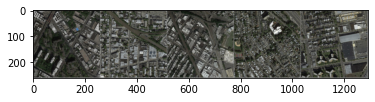

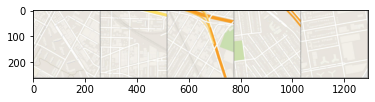

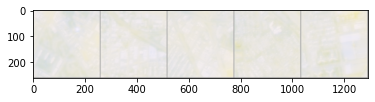

Epochs: 14 Step: 1000 Generator loss: 15.14906436920166, discriminator loss: 0.006929668206721544


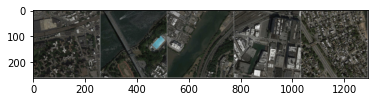

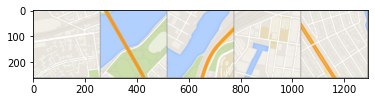

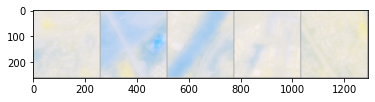

Epochs: 15 Step: 1100 Generator loss: 15.39568811416626, discriminator loss: 0.005415239674039185


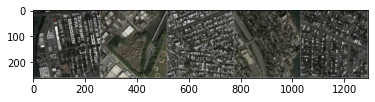

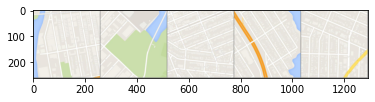

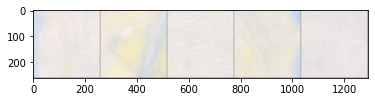

Epochs: 17 Step: 1200 Generator loss: 15.53686734199524, discriminator loss: 0.004337222375907004


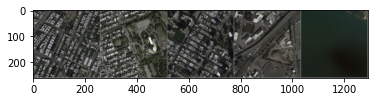

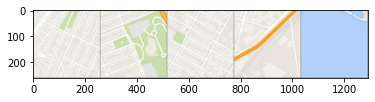

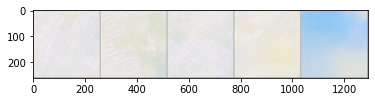

Epochs: 18 Step: 1300 Generator loss: 15.78480429649353, discriminator loss: 0.0035214468813501297


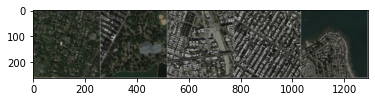

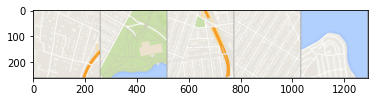

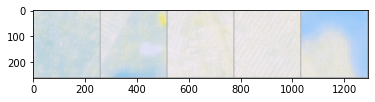

In [14]:
current_step = 0
gen_losses = 0
disc_losses = 0
os.makedirs("pix2pix", exist_ok=True)

for epoch in range(n_epochs):
    for sat, real in dataloader :
        current_batch_size = len(real)
        sat = sat.to(device)
        real = real.to(device)
        
        disc_opt.zero_grad()
        fake_img = gen(sat)
        disc_preds_fake = disc(fake_img.detach(), sat)
        disc_fake_loss = gan_criterion1(disc_preds_fake, torch.zeros_like(disc_preds_fake))
        disc_preds_real = disc(real, sat)
        disc_real_loss = gan_criterion1(disc_preds_real, torch.ones_like(disc_preds_real))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph = True)
        disc_opt.step()
        disc_losses += disc_loss.item()
        
        gen_opt.zero_grad()
        fake_img2 = gen(sat)
        disc_preds_fake = disc(fake_img2, sat)
        gen_loss1 = gan_criterion1(disc_preds_fake, torch.ones_like(disc_preds_fake))
        gen_loss2 = gan_criterion2(real, fake_img2)
        gen_loss = gen_loss1 + 100*gen_loss2
        gen_loss.backward()
        gen_opt.step()
        gen_losses += gen_loss.item()
        
        if current_step % steps == 0 and current_step > 0 :
            print(f"Epochs: {epoch} Step: {current_step} Generator loss: {gen_losses / steps}, discriminator loss: {disc_losses / steps}")
            img_grid_sat = torchvision.utils.make_grid(sat[:5], nrow = 5)
            img_grid_real = torchvision.utils.make_grid(real[:5], nrow = 5)
            img_grid_fake = torchvision.utils.make_grid(fake_img[:5], nrow = 5)
            save_image(fake_img2.data[:5], "pix2pix/%d.png" % current_step, nrow=5, normalize=True)
            matplotlib_imshow(img_grid_sat, one_channel=False)
            matplotlib_imshow(img_grid_real,  one_channel=False)
            matplotlib_imshow(img_grid_fake,  one_channel=False)
            gen_losses = 0
            disc_losses = 0
        
        current_step += 1

        